In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import sqlite3

<h2>Get Data</h2>

In [2]:
BASE_URL = "https://newyork.craigslist.org/search/apa"
headers = {
    "User-Agent": (
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"
    )
}

results = []
html_text = requests.get(BASE_URL, headers=headers).text
soup = BeautifulSoup(html_text, "lxml")
apartments = soup.find_all("li", class_="cl-static-search-result")
for apt in apartments:
    apt_title = apt.find("div", class_="title").text.strip()
    apt_price = apt.find("div", class_="price").text.strip()
    apt_location = apt.find("div", class_="location").text.strip()
    results.append({
        "Title": apt_title,
        "Price": apt_price,
        "Location": apt_location,
    })

<h2>Clean Data</h2>

In [3]:
df = pd.DataFrame(results)
df["Price"] = (
    df["Price"].str.replace("$", "", regex=False).str.replace(",", "", regex=False).astype(int)
)
df["Location"] = (
    df["Location"].str.strip().str.title()
)
df

,Title,Price,Location
0,Affordable 3-Bedroom Home with Off-Street Park...,1760,Brooklyn
1,3 large bedroom /2 bathroom and balcony $2800 ...,3778,Bronx
2,Sunny Bright Convertible 3 Bedroom,5595,Midtown West
3,Large Bright Convertible 3 Bedroom,5495,Midtown West
4,EAST VILLAGE 2 bedrooms available,4400,East Village
...,...,...,...
349,Williamsburg/ Greenpoint - Luxury 2 Bedroom - ...,4400,Williamsburg
350,Corner 1BR in The Hayden LIC 740 Sqft Starting...,4869,Long Island City
351,Prospect Heights - Beautiful 1 Bedroom - Share...,2500,Prospect Heights
352,Crown heights / Prospect heights - Luxury 2 Be...,4000,Prospect Heights / Crown Heights


<h2>Price Distribution</h2>

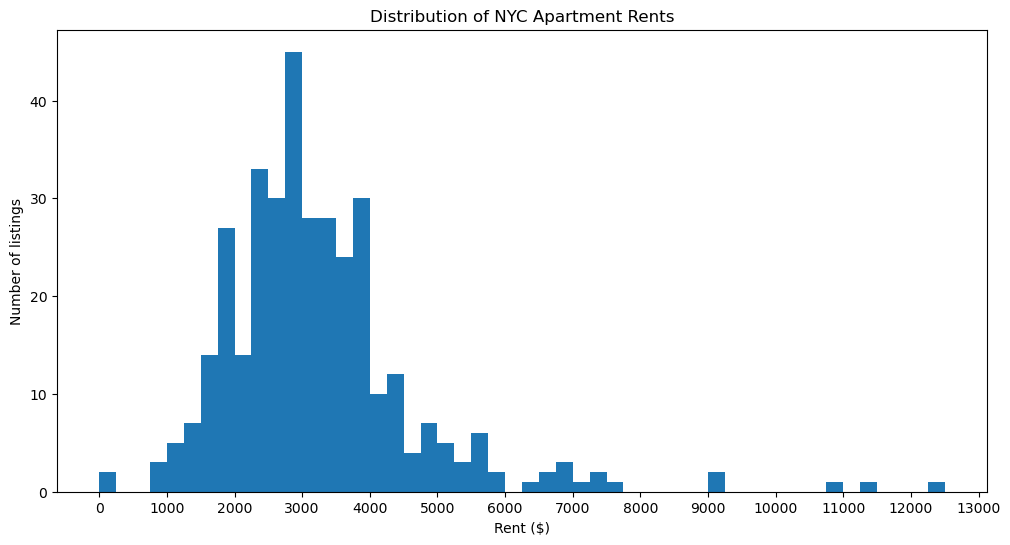

In [4]:
plt.figure(figsize=(12, 6))  # wider plot
plt.hist(df["Price"], bins=50)
plt.xlabel("Rent ($)")
plt.xticks(np.arange(0, df["Price"].max() + 1000, 1000))
plt.ylabel("Number of listings")
plt.title("Distribution of NYC Apartment Rents")
plt.show()

<h2>Median Rent By Location</h2>

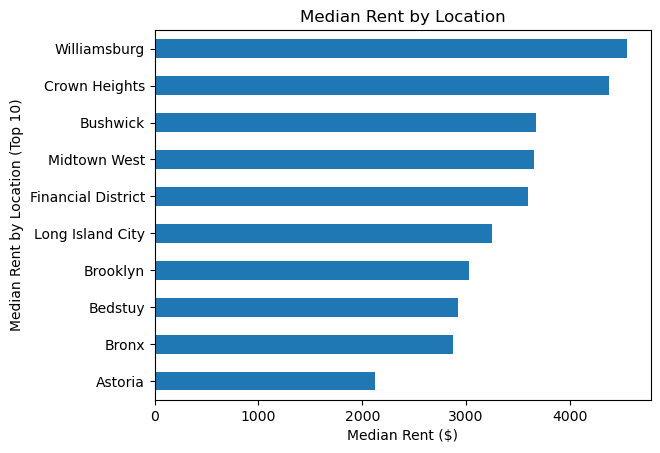

In [5]:
top_locations = df["Location"].value_counts().head(10).index
median_by_location = (
    df[df["Location"].isin(top_locations)].groupby("Location")["Price"].median().sort_values()
)
median_by_location.plot(kind="barh")
plt.xlabel("Median Rent ($)")
plt.ylabel("Median Rent by Location (Top 10)")
plt.title("Median Rent by Location")
plt.show()

<h2>Fair Price by Median</h2>

In [12]:
median_price = df["Price"].median()
print(f"Median (Fair) Price: ${median_price:.0f}")
df["Price vs Median"] = df["Price"] - median_price
df["Percent vs Median"] = ((df["Price vs Median"] / median_price) * 100).round(2)

overpriced = df[df["Percent vs Median"] > 30].sort_values("Percent vs Median", ascending=False)
overpriced_clean = overpriced[["Title", "Location", "Price", "Percent vs Median"]].head(10).copy()
print(f"\nOverpriced listings (>30% above ${median_price:.0f}):")
print(overpriced_clean.to_string(index=False))

print("\n" + "="*100)

deals = df[df["Percent vs Median"] < -30].sort_values("Percent vs Median")
deals_clean = deals[["Title", "Location", "Price", "Percent vs Median"]].head(10).copy()
print(f"\nGreat Deals (<30% below ${median_price:.0f}):")
print(deals_clean.to_string(index=False))

Median (Fair) Price: $3000

Overpriced listings (>30% above $3000):
                                                                 Title           Location  Price  Percent vs Median
              🔥🔑Spacious 3 Bed / 2 Bath Duplex with Private Backyard🔥🔑       Williamsburg  12500             316.67
Stunning 4BR / 2.5BA with Huge Private Backyard & In-Unit Washer/Dryer       Williamsburg  11500             283.33
  Rare Dplx Apt _ Private Garden & Working  FPL off CPW. W 80s. No Fee    Upper West Side  11000             266.67
          NO FEE / EXPANSIVE 2-Floor Duplex / 7-Bed 3-Bath / Renovated Bedford-Stuyvesant   9013             200.43
            🔥🔑Massive 7 Bed / 3 Bath Duplex | In-Unit W/D | Bed-Stuy🔥🔑           Bed Stuy   9013             200.43
                Gorgeous West Vil townhouse 1br w/huge terrace, VIDEO!       West Village   7600             153.33
                               High Flr! Sun Filled and Spacious unit!   Long Island City   7450             148.33
    

<h2>Fair Price by IQR</h2>

In [14]:
Q1 = df["Price"].quantile(0.25)
Q2 = df["Price"].quantile(0.50)
Q3 = df["Price"].quantile(0.75)

print(f"Price Ranges:")
print(f"  Bottom 25%: ${Q1:.0f}")
print(f"  Bottom 50%: ${Q2:.0f}")
print(f"  Bottom 75%: ${Q3:.0f}")

def price_category(price):
    if price < Q1:
        return "Below Market"
    elif price <= Q3:
        return "Fair Price"
    else:
        return "Overpriced"

df["Price_Category"] = df["Price"].apply(price_category)

print("\nPrice distribution:")
print(df["Price_Category"].value_counts())

print("\nFair Price listings:")
fair_price_listings = df[df["Price_Category"] == "Fair Price"][["Title", "Location", "Price"]].head(10).copy()
print(fair_price_listings.to_string(index=False))

print("\n" + "="*100)
print("\nBelow Market listings:")
below_market_listings = df[df["Price_Category"] == "Below Market"][["Title", "Location", "Price"]].head(10).copy()
print(below_market_listings.to_string(index=False))

print("\n" + "="*100)
print("\nOverpriced listings:")
overpriced_listings = df[df["Price_Category"] == "Overpriced"][["Title", "Location", "Price"]].head(10).copy()
print(overpriced_listings.to_string(index=False))

Price Ranges:
  Bottom 25%: $2450
  Bottom 50%: $3000
  Bottom 75%: $3795

Price distribution:
Price_Category
Fair Price      180
Overpriced       88
Below Market     86
Name: count, dtype: int64

Fair Price listings:
                                                          Title           Location  Price
      3 large bedroom /2 bathroom and balcony $2800 must go !!!              Bronx   3778
         Modern Ridgewood Oasis | 2BR/2BA | Roommate Perfection          Ridgewood   3200
                           Alcove Studio, Convertible 1 Bedroom       Midtown West   3095
                      Bright, Renovated Studio, Laundry in Unit       Midtown West   3095
                                            Large Bright Studio       Midtown West   3095
                                            3 br   2 bath $3000            Bayside   3000
                          Bright, New, Floor to Ceiling Windows       Midtown West   3195
                          East Village 1 Bedrooms available NO

<h2>Custom Fair Price</h2>

In [15]:
def calculate_fair_rent(monthly_income, savings_percent, investment_percent, costs_percent):
    savings = monthly_income * (savings_percent / 100)
    investments = monthly_income * (investment_percent / 100)
    costs = monthly_income * (costs_percent / 100)
    remaining_for_rent = monthly_income - savings - investments - costs
    print(f"\n{"="*150}")
    print(f"Monthly Income (after taxes): ${monthly_income:,.2f}")
    print(f"{"="*150}")
    print(f"Savings: ${savings:,.2f}")
    print(f"Investments: ${investments:,.2f}")
    print(f"External Costs: ${costs:,.2f}")
    print(f"Available for Rent: ${remaining_for_rent:,.2f}")
    print(f"{"-"*150}")
    return remaining_for_rent

monthly_income = float(input("Enter your monthly income (after taxes): $"))
savings_percent = float(input("What % goes into savings? "))
investments_percent = float(input("What % goes into investments? "))
costs_percent = float(input("What % goes into other costs (non-rent)? "))
fair_rent = calculate_fair_rent(monthly_income, savings_percent, investments_percent, costs_percent)

affordable = df[df["Price"] <= fair_rent].copy()
print(f"Affordable: {len(affordable)} listings")
print(f"Top 5 Affordable Options:")
affordable_clean = affordable.nsmallest(5, "Price")[["Title", "Location", "Price"]].copy()
print(affordable_clean.to_string(index=False))

print(f"{"="*150}")

slightly_over = df[(df["Price"] > fair_rent) & (df["Price"] <= fair_rent * 1.1)].copy()
print(f"Slightly Over: {len(slightly_over)} listings")
print(f"Top 5 Slightly Over Options:")
slightly_over_clean = slightly_over.nsmallest(5, "Price")[["Title", "Location", "Price"]].copy()
print(slightly_over_clean.to_string(index=False))

print(f"{"="*150}")

expensive = df[df["Price"] > fair_rent * 1.1].copy()
print(f"Expensive: {len(expensive)} listings")
print(f"Top 5 Expensive Options:")
expensive_clean = expensive.nsmallest(5, "Price")[["Title", "Location", "Price"]].copy()
print(expensive_clean.to_string(index=False))

Enter your monthly income (after taxes): $ 20000
What % goes into savings?  10
What % goes into investments?  50
What % goes into other costs (non-rent)?  15



Monthly Income (after taxes): $20,000.00
Savings: $2,000.00
Investments: $10,000.00
External Costs: $3,000.00
Available for Rent: $5,000.00
------------------------------------------------------------------------------------------------------------------------------------------------------
Affordable: 323 listings
Top 5 Affordable Options:
                                                           Title                                          Location  Price
                           $1,75o 2Bed 1Bath ~ 15mins to Midtown                          48St, Woodside/Sunnyside      1
            $2,4oo 2Bed 1Bath w/Elevator+Laundry+Rooftop+Parking 20Mins To Midtown! 64St, Woodside ~ Near #7 Train      2
32-85 33RD STREET STUDIO  850 WITH SHARE  KITCHEN NEAR N Q TRAIN                                           Astoria    850
32-85 33RD STREET STUDIO  850 WITH SHARE  KITCHEN NEAR N Q TRAIN                                           Astoria    850
                                               

<h2>Load Data into SQLite Database</h2>

In [16]:
conn = sqlite3.connect("nyc_craigslist_rentals.db")
df.to_sql("listings", conn, if_exists="replace", index=False)
df_check = pd.read_sql("SELECT * FROM listings LIMIT 5", conn)
print(df_check)
conn.close()

                                               Title  Price      Location  \
0  Affordable 3-Bedroom Home with Off-Street Park...   1760      Brooklyn   
1  3 large bedroom /2 bathroom and balcony $2800 ...   3778         Bronx   
2                 Sunny Bright Convertible 3 Bedroom   5595  Midtown West   
3                 Large Bright Convertible 3 Bedroom   5495  Midtown West   
4                  EAST VILLAGE 2 bedrooms available   4400  East Village   

   Price vs Median  Percent vs Median Price_Category  
0          -1240.0             -41.33   Below Market  
1            778.0              25.93     Fair Price  
2           2595.0              86.50     Overpriced  
3           2495.0              83.17     Overpriced  
4           1400.0              46.67     Overpriced  
